 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/Documents/17F532IE/PageRank/Draft.ipynb#Reference" data-toc-modified-id="Reference-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reference</a></span></li><li><span><a href="http://localhost:8888/notebooks/Documents/17F532IE/PageRank/Draft.ipynb#Code" data-toc-modified-id="Code-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Code</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/Documents/17F532IE/PageRank/Draft.ipynb#generate-graph" data-toc-modified-id="generate-graph-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>generate graph</a></span></li><li><span><a href="http://localhost:8888/notebooks/Documents/17F532IE/PageRank/Draft.ipynb#simple-neural-network" data-toc-modified-id="simple-neural-network-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>simple neural network</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/Documents/17F532IE/PageRank/Draft.ipynb#测试前要看一下" data-toc-modified-id="测试前要看一下-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>测试前要看一下</a></span></li></ul></li></ul></li></ul></div>

# Reference

https://medium.com/@bgoncalves/network-effects-explained-pagerank-and-preferential-attachment-61fdf93d023a

# Code

## generate graph

In [1]:
import networkx as nx

In [2]:
with open("web-Stanford.txt","r") as fil:
    for _ in range(4):
        next(fil)
    data=[tuple([int(j) for j in i.strip().split()]) for i in fil]

In [3]:
G = nx.DiGraph()
G.add_edges_from(data)

pr = nx.pagerank(G, alpha=0.9)   #作为true response?

In [4]:
for i in pr.keys():
    G[i]['score']=pr[i]

In [5]:
G[1]['score']

3.561215144991757e-07

In [6]:
n=len(G.nodes())

A Sidenote:

要解释什么是damping factor:

The damping factor is the click-through probability, is included to prevent sinks (i.e. pages with no outgoing links) from "absorbing" the PageRanks of those pages connected to the sinks.  
- You can see that if it equals to 1, the person clicking will click forever and they will always end up in a sink. 

- On the other hand, if the click-through probability is 0, then all clicks are random restarts, which are uniformly distributed.

So, a damping factor is a weighted average between the two extremes.

### Preferential Attachment Model
命名和上一个一样，可以先拿以下的代码试验，数据小跑起来比较快

In [2]:
# G_temp = nx.barabasi_albert_graph(1000, 1)
G_temp = nx.watts_strogatz_graph(1000, 10, 0.05) # Small world with low rewiring probability
# G_temp = nx.watts_strogatz_graph(1000, 10, 0.9) # Small world with high rewiring probability

# initialize an empty directed graph
G = nx.DiGraph()
G.add_edges_from(G_temp.edges())

pr = nx.pagerank(G, alpha = 0.85) 
for i in pr.keys():
    G[i]['score']=pr[i]

In [3]:
G[0]['score']

0.0001538659016566698

In [4]:
n = len(G.nodes())

## Simple Neural Network

In [5]:
from __future__ import division
from __future__ import print_function

import time
import tensorflow as tf
from gcn.utils import *
from gcn.models import Model,MLP
from gcn.layers import *

import scipy.sparse as sp
import random
import numpy as np

### 测试前要看一下
+ 之前学习率填了0.05，明显训练的时候有了误差来回变大减小又变大再减小的情况，应该要调小一点，之前作业里是0.01,我一时兴起又改大了……
+ 用networkx里的pagerank算法出来的分数是在0-1之间，所以最后的误差出来即使是0.几，也不确定是不是很好，这里是100个点做validation。
+ epoch可能也要调，学习率0.05的时候300差不多收敛了，但是不知道学习率改了之后是什么情况

In [6]:
# Set random seed
seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)

# Settings
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('dataset', 'cora', 'Dataset string.')  # 'cora', 'citeseer', 'pubmed'  #这行应该并没有什么用
flags.DEFINE_string('model', 'gcn', 'Model string.')  # 'gcn', 'gcn_cheby', 'dense'
flags.DEFINE_float('learning_rate', 0.1, 'Initial learning rate.')
#flags.DEFINE_float('learning_rate', 0.1, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 300, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0.1, 'Dropout rate (1 - keep probability).')
#flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')
#flags.DEFINE_float('weight_decay', 0, 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 100, 'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')

If you assume the target is continuous (like PageRank scores here) and normally distributed, and you maximize the likelihood of the output of the net under these assumptions, you get the MSE (combined with a linear output layer).

In [7]:
def masked_mean_square_error(preds,labels,mask):
    """L2 loss with masking."""
    loss = tf.nn.l2_loss(preds - labels)   
    # loss = tf.nn.relu(preds - labels) Rulu loss
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

# 定义另一个loss function
def masked_absolute_difference(preds,labels,mask):
    """Log Loss with masking"""
    loss = tf.losses.absolute_difference(labels = labels, predictions = preds)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

#--------------------Evaluation function------------------------#
## 因为response是continuous，是不是应该用RMSE instead of accuracy? (accuracy是针对分类问题)
## *计算方法改成了rmse,但函数名仍然是accuracy，因为要改的地方太多，我怕漏了，就没改
## 我们自己知道就行
def masked_accuracy(preds, labels, mask):
    """Root Mean Square Error with masking"""
    rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(preds, labels)))
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    rmse *= mask
    return tf.reduce_mean(rmse)

**Cross Entropy vs. Mean Square Error**

Cross-entropy is prefered for **classification**, while mean squared error is one of the best choices for **regression**. This comes directly from the statement of the problems itself - in classification you work with very particular set of possible output values thus MSE is badly defined (as it does not have this kind of knowledge thus penalizes errors in incompatible way). 

In [8]:
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # loss function 可尝试多种
        self.loss += masked_mean_square_error(self.outputs, self.placeholders['labels'],
                                                 self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return self.outputs    #tf.nn.softmax(self.outputs)

In [9]:
def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)

# A^2
#    adj_square = np.power(adj,2).tocoo()
#    return sparse_to_tuple(adj)

In [10]:
# Randomly generate graph with 500 nodes
adj = nx.adjacency_matrix(G)

# Generate feature matrix  #there is difference between different version of networkx, 这里是用networkx 2.0. 原来1.1的用法注释掉了
#features = sp.vstack(list(j[1] for j in G.in_degree(G.nodes())),dtype = 'float32').tolil()
features = sp.vstack(list(G.in_degree(G.nodes()).values()),dtype = 'float32').tolil()   

# Feed labels to 20 nodes
label = []
for i in G.nodes():
    #label.append(G.nodes[i]['score']) 我用的1.1语法-yiming
    label.append(G[i]['score'])
        
alabel = np.array(label, dtype='float64')

idx_train = range(800)
idx_val = range(800, 800 + 100) #20000改到500 for preferential attachment model

y_train = np.zeros([n, 1])   #n is number of total nodes, =281903
train_mask = np.zeros([n, ], dtype = 'bool')
for i in idx_train:
    y_train[i] = alabel[i]
    train_mask[i] = True

y_val = np.zeros([n, 1])
val_mask = np.zeros([n, ], dtype = 'bool')
for i in idx_val:
    y_val[i] = alabel[i]
    val_mask[i] = True

In [11]:
# Load data
#adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(FLAGS.dataset)

# Some preprocessing
features = preprocess_features(features)
if FLAGS.model == 'gcn':
    support = [preprocess_adj(adj)]
    num_supports = 1
    model_func = GCN
elif FLAGS.model == 'gcn_cheby':
    support = chebyshev_polynomials(adj, FLAGS.max_degree)
    num_supports = 1 + FLAGS.max_degree
    model_func = GCN
elif FLAGS.model == 'dense':
    support = [preprocess_adj(adj)]  # Not used
    num_supports = 1
    model_func = MLP
else:
    raise ValueError('Invalid argument for model: ' + str(FLAGS.model))

# Define placeholders
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

# Create model
model = model_func(placeholders, input_dim=features[2][1], logging=True)

# Initialize session
sess = tf.Session()


# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)

/Users/Yiming/Desktop/Homework/IE 532/Project/gcn/utils.py:97: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


In [12]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_rmse = []
validation_rmse = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_rmse.append(acc)
    train_loss.append(outs[1])
    train_rmse.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_rmse=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_rmse=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 8.27889 train_rmse= 0.12867 val_loss= 106.60499 val_rmse= 0.46175 time= 0.02576
Epoch: 0002 train_loss= 112.39001 train_rmse= 0.47411 val_loss= 11.65066 val_rmse= 0.15265 time= 0.00390
Epoch: 0003 train_loss= 14.05488 train_rmse= 0.16766 val_loss= 15.29823 val_rmse= 0.17492 time= 0.00361
Epoch: 0004 train_loss= 23.55723 train_rmse= 0.21706 val_loss= 30.05159 val_rmse= 0.24516 time= 0.00366
Epoch: 0005 train_loss= 31.75224 train_rmse= 0.25200 val_loss= 15.04723 val_rmse= 0.17348 time= 0.00328
Epoch: 0006 train_loss= 17.38722 train_rmse= 0.18648 val_loss= 0.60944 val_rmse= 0.03491 time= 0.00336
Epoch: 0007 train_loss= 1.72165 train_rmse= 0.05868 val_loss= 15.90842 val_rmse= 0.17837 time= 0.00436
Epoch: 0008 train_loss= 17.32226 train_rmse= 0.18613 val_loss= 10.18412 val_rmse= 0.14272 time= 0.00355
Epoch: 0009 train_loss= 11.49868 train_rmse= 0.15165 val_loss= 0.99315 val_rmse= 0.04456 time= 0.00342
Epoch: 0010 train_loss= 3.42225 train_rmse= 0.08273 val_loss= 1.63

Epoch: 0101 train_loss= 0.08127 train_rmse= 0.01271 val_loss= 0.00182 val_rmse= 0.00160 time= 0.00479
Epoch: 0102 train_loss= 0.08791 train_rmse= 0.01322 val_loss= 0.00110 val_rmse= 0.00106 time= 0.00500
Epoch: 0103 train_loss= 0.12858 train_rmse= 0.01600 val_loss= 0.00062 val_rmse= 0.00039 time= 0.00853
Epoch: 0104 train_loss= 0.08030 train_rmse= 0.01263 val_loss= 0.00196 val_rmse= 0.00168 time= 0.00547
Epoch: 0105 train_loss= 0.08685 train_rmse= 0.01314 val_loss= 0.00614 val_rmse= 0.00334 time= 0.00734
Epoch: 0106 train_loss= 0.08499 train_rmse= 0.01300 val_loss= 0.01124 val_rmse= 0.00462 time= 0.00544
Epoch: 0107 train_loss= 0.08894 train_rmse= 0.01330 val_loss= 0.01537 val_rmse= 0.00545 time= 0.00687
Epoch: 0108 train_loss= 0.07468 train_rmse= 0.01218 val_loss= 0.01680 val_rmse= 0.00570 time= 0.00481
Epoch: 0109 train_loss= 0.08966 train_rmse= 0.01335 val_loss= 0.01275 val_rmse= 0.00494 time= 0.00665
Epoch: 0110 train_loss= 0.08895 train_rmse= 0.01330 val_loss= 0.00678 val_rmse= 0.

Epoch: 0205 train_loss= 0.02962 train_rmse= 0.00763 val_loss= 0.00205 val_rmse= 0.00175 time= 0.00388
Epoch: 0206 train_loss= 0.01890 train_rmse= 0.00606 val_loss= 0.00174 val_rmse= 0.00156 time= 0.00469
Epoch: 0207 train_loss= 0.02209 train_rmse= 0.00657 val_loss= 0.00117 val_rmse= 0.00113 time= 0.00415
Epoch: 0208 train_loss= 0.01897 train_rmse= 0.00607 val_loss= 0.00073 val_rmse= 0.00065 time= 0.00460
Epoch: 0209 train_loss= 0.01959 train_rmse= 0.00617 val_loss= 0.00059 val_rmse= 0.00036 time= 0.00436
Epoch: 0210 train_loss= 0.02191 train_rmse= 0.00654 val_loss= 0.00061 val_rmse= 0.00041 time= 0.00491
Epoch: 0211 train_loss= 0.01961 train_rmse= 0.00618 val_loss= 0.00062 val_rmse= 0.00043 time= 0.00517
Epoch: 0212 train_loss= 0.01707 train_rmse= 0.00575 val_loss= 0.00061 val_rmse= 0.00041 time= 0.00706
Epoch: 0213 train_loss= 0.01694 train_rmse= 0.00573 val_loss= 0.00059 val_rmse= 0.00036 time= 0.00402
Epoch: 0214 train_loss= 0.02073 train_rmse= 0.00636 val_loss= 0.00062 val_rmse= 0.

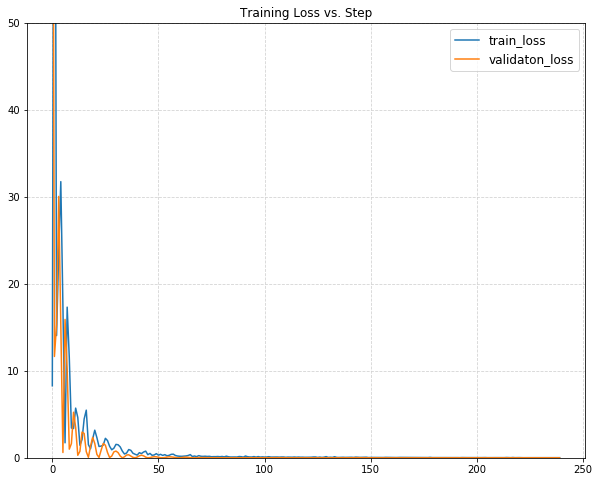

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10, 8))
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_loss,label='validaton_loss')
plt.ylim(0, 50)
plt.legend(prop={'size': 12})
plt.grid(color = 'lightgray', linestyle = '--')
plt.title('Training Loss vs. Step')
# plt.savefig("3loss.png") 
plt.show()

**1.png** Stop at Epoch 163.
- Model: Small World Model (p = 0.05)
- Learning Rate = 0.01
- Drop-out Rate = 0.1
- Cost function: masked_mean_square_error
- Evaluation function: masked_accuracy (其实是RMSE)
- Adjacency matrix: A
- Weight decay: Yes



**2.png** Stop at Epoch 222.
- Model: Small World Model (p = 0.05)
- Learning Rate = 0.05
- Drop-out Rate = 0.1
- Cost function: masked_mean_square_error
- Evaluation function: masked_accuracy (其实是RMSE)
- Adjacency matrix: A
- Weight decay: Yes


**3.png** Stop at Epoch 240. If drop-out rate = 0.5, won't early stop.
- Model: Small World Model (p = 0.05)
- Learning Rate = 0.1
- Drop-out Rate = 0.1
- Cost function: masked_mean_square_error
- Evaluation function: masked_accuracy (其实是RMSE)
- Adjacency matrix: A
- Weight decay: Yes

**4.png** Stop at Epoch 129.
- Model: Small World Model (p = 0.05)
- Learning Rate = 0.01
- Drop-out Rate = 0.1
- Cost function: masked_mean_square_error
- Evaluation function: masked_accuracy (其实是RMSE)
- Adjacency matrix: A
- Weight decay: Yes


**5.png** Stop at Epoch 148.
- Model: Small World Model (p = 0.05)
- Learning Rate = 0.01
- Drop-out Rate = 0.3
- Cost function: masked_mean_square_error
- Evaluation function: masked_accuracy (其实是RMSE)
- Adjacency matrix: A
- Weight decay: Yes

**6.png** Stop at Epoch 185.
- Model: Small World Model (p = 0.05)
- Learning Rate = 0.01
- Drop-out Rate = 0.5
- Cost function: masked_mean_square_error
- Evaluation function: masked_accuracy (其实是RMSE)
- Adjacency matrix: A
- Weight decay: Yes



- 若learning rate = 0.01, train_loss一开始很大，在epoch = 100左右急剧减小
- 若learning rate = 0.05, train_loss一开始很大，在epoch = 20左右急剧减小

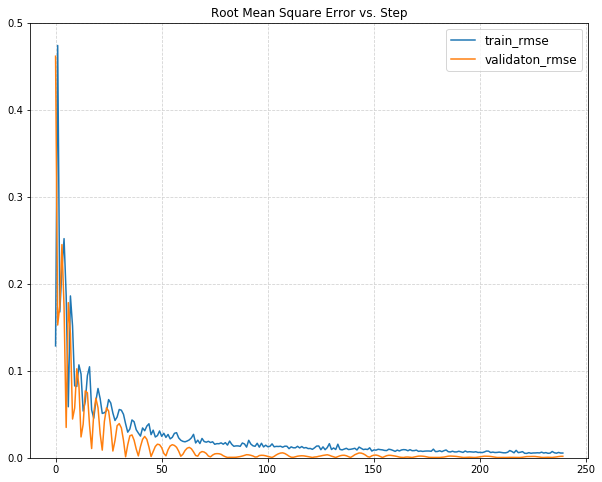

In [21]:
fig, ax = plt.subplots(figsize = (10, 8))
plt.plot(train_rmse,label = 'train_rmse')
plt.plot(validation_rmse,label='validaton_rmse')
plt.ylim(0, 0.5)
plt.legend(prop={'size': 12})
plt.grid(color = 'lightgray', linestyle = '--')
plt.title('Root Mean Square Error vs. Step')
#plt.savefig("3rmse.png") # 保存图片放在slides上
plt.show()

Presentation时可以做的几个比较 （保持其余参数尽可能结果最好）：

1. 不同的learning_rate (Yiming)
2. 不同的drop_out rate (Yiming)
3. 不同的Loss function (Yiming/ Yiqin)
4. 有无weight_decay (Yiqin)
5. 不同的adjacency matrix, A, A^2等等 (Yiqin)

这些是train on small graphs, test on large graph?? (stanford data)

Side note for Yiqin:
现在的evaluate我是用的root mean square error，可以参见上面的注释，可能还可以试一下别的evaluation function for continuous response.

我觉得presentation是图片越多越好，别人可能对定理没什么兴趣= =

谢谢你啦！！


*还需要test data